In [1]:
from torch import nn
from torchsummary import summary
import torch 
# from U2Net_.model import U2NET
from scipy import ndimage
import PIL
import random

import os
import pydiffvg
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import warp
from skimage import transform as tf
import imageio 
import matplotlib.font_manager as font_manager
import skimage
import skimage.io
from torchvision import transforms
import os, sys
import PIL

import collections
# import clip
import torch
import torch.nn as nn
from torchvision import models, transforms

p = os.path.abspath('..')
sys.path.insert(1, p)
import sketch_utils as utils
from U2Net_.model import U2NET
import CLIP_.clip as clip
from scipy import ndimage
from torchvision.utils import make_grid

device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")

In [2]:
def get_initial_points(path_svg, target_, device):
    target = torch.from_numpy(skimage.io.imread(target_)).to(torch.float32) / 255.0
    # target = target.pow(gamma)
    target = target.to(pydiffvg.get_device())
    target = target.unsqueeze(0)
    target = target.permute(0, 3, 1, 2) # NHWC -> NCHW
    
    canvas_width, canvas_height, shapes, shape_groups = pydiffvg.svg_to_scene(
        path_svg)
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)

    points_vars = []
    for i, path in enumerate(shapes):
        points_vars.append(path.points)
    
    plt.imshow(img.cpu().numpy())
    plt.show()
    return points_vars

def get_path(inds_normalised, strokes_counter, device, num_segments=1, control_points_per_seg=4, canvas_width=224, canvas_height=224):
    points = []
    num_control_points = torch.zeros(num_segments, dtype = torch.int32) + (control_points_per_seg - 2)
    p0 = inds_normalised[strokes_counter]
    points.append(p0)

    for j in range(num_segments):
        radius = 0.05
        for k in range(control_points_per_seg - 1):
            p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
            points.append(p1)
            p0 = p1
    points = torch.tensor(points).to(device)
    points[:, 0] *= canvas_width
    points[:, 1] *= canvas_height

    path = pydiffvg.Path(num_control_points = num_control_points,
                            points = points,
                            stroke_width = torch.tensor(1.5),
                            is_closed = False)
    return path



def render_points(points, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224):
    all_points = 0.5 * (points + 1.0) * canvas_size
    eps = 1e-4
    all_points = all_points + eps*torch.randn_like(all_points)
    all_points = all_points.reshape((-1, num_strokes, num_cp, 2))
    num_control_points = torch.zeros(1, dtype = torch.int32) + (4 - 2)

    shapes = []
    shape_groups = []
    for p in range(num_strokes):
        path = pydiffvg.Path(
            num_control_points=num_control_points, points=all_points[:,p].reshape((-1,2)),
            stroke_width=torch.tensor(1.5), is_closed=False)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(
            shape_ids=torch.tensor([len(shapes) - 1]),
            fill_color=None,
            stroke_color=torch.tensor([0,0,0,1]))
        shape_groups.append(path_group)

    # Rasterize
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
        
    # plt.imshow(img.detach().cpu().numpy())
    # plt.show()
    return img
    

def get_target(target_, device, image_scale=224):
    target = Image.open(target_)
    if target.mode == "RGBA":
        # Create a white rgba background
        new_image = Image.new("RGBA", target.size, "WHITE")
        # Paste the image on the background.
        new_image.paste(target, (0, 0), target)
        target = new_image
    target = target.convert("RGB")

    transforms_ = []
    if target.size[0] != target.size[1]:
        transforms_.append(transforms.Resize(
            (image_scale, image_scale), interpolation=PIL.Image.BICUBIC))
    else:
        transforms_.append(transforms.Resize(
            image_scale, interpolation=PIL.Image.BICUBIC))
        transforms_.append(transforms.CenterCrop(image_scale))
    transforms_.append(transforms.ToTensor())
    data_transforms = transforms.Compose(transforms_)
    target_ = data_transforms(target).unsqueeze(0).to(device)
    masked_im, mask = get_mask_u2net(target_, device, use_gpu=True)
    return target_, mask
    
def get_mask_u2net(tensor_im, device, use_gpu=True):
    data_transforms = transforms.Compose([
        # transforms.ToTensor(),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(
            0.26862954, 0.26130258, 0.27577711)),
    ])

    input_im_trans = data_transforms(tensor_im).to(device)

    model_dir = os.path.join("/home/vinker/dev/backgroundCLIPasso/CLIPasso/U2Net_/saved_models/u2net.pth")
    net = U2NET(3, 1)
    if torch.cuda.is_available() and use_gpu:
        net.load_state_dict(torch.load(model_dir, map_location=torch.device("cuda:2")))
        net.to(device)
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()
    with torch.no_grad():
        d1, d2, d3, d4, d5, d6, d7 = net(input_im_trans.detach())
    pred = d1[:, 0, :, :]
    pred = (pred - pred.min()) / (pred.max() - pred.min())
    predict = pred
    predict[predict < 0.5] = 0
    predict[predict >= 0.5] = 1
    
    # print(predict[0].shape, ndimage.generate_binary_structure(5, 5).shape)
    predict = 1 - torch.tensor(ndimage.binary_dilation(predict[0].cpu().numpy(), structure=np.ones((11,11))).astype(np.int)).unsqueeze(0).to(device)
    mask = torch.cat([predict, predict, predict], axis=0).permute(1, 2, 0)
    mask = mask.cpu().numpy()
    
    # print(mask.max(), mask.dtype)
    # predict_np = predict.clone().cpu().data.numpy()
    im = Image.fromarray((mask[:, :, 0]*255).astype(np.uint8)).convert('RGB')
    # im.save(f"{args.output_dir}/mask.png")

    im_np = tensor_im[0].permute(1,2,0).cpu().numpy()
    im_np = im_np / im_np.max()
    im_np = mask * im_np
    im_np[mask == 0] = 1
    im_final = (im_np / im_np.max() * 255).astype(np.uint8)
    im_final = Image.fromarray(im_final)

    return im_final, predict



def get_initial_points_mask(mask, num_strokes, device, canvas_width=224, canvas_height=224):
    # print(mask.shape)
    mask = mask[0].cpu().numpy().astype(float)
    mask[mask > 0] = mask[mask > 0] / mask.sum()
    mask_prob = mask.astype(float) 
    # mask_prob = 
    # print(mask_prob.sum())
    k = num_strokes
    inds = np.random.choice(range(mask_prob.flatten().shape[0]), size=k, replace=False, p=mask_prob.flatten())
    inds = np.array(np.unravel_index(inds, mask_prob.shape)).T
    # print(inds)
    inds_normalised = np.zeros(inds.shape)
    inds_normalised[:, 0] =  inds[:, 1] / canvas_width
    inds_normalised[:, 1] =  inds[:, 0] / canvas_height
    inds_normalised = inds_normalised.tolist()
    # print(inds_normalised)
    shape_groups, shapes = [], []
    for i in range(num_strokes):
        # print(i)
        stroke_color = torch.tensor([0.0, 0.0, 0.0, 1.0])
        path = get_path(inds_normalised, i, device)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),
                                            fill_color = None,
                                            stroke_color = stroke_color)
        shape_groups.append(path_group)
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)

    points_vars = []
    for i, path in enumerate(shapes):
        points_vars.append(path.points)
    
    plt.imshow(img.cpu().numpy())
    plt.show()
    return points_vars

    
def optimize_through_net(target, points_vars, mlp, mlp_opt, loss_clip, device, canvas_size=224, num_strokes=32, num_cp=4, num_iter=10, print_interval=10):    
    for t in range(num_iter):
        mlp_opt.zero_grad()
        points = mlp(points_vars)
        img = render_points(points, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
        if t % print_interval == 0:
            print('iteration:', t)
            plt.imshow(img.cpu().detach().numpy())
            plt.show()
            plt.close()
            
        img = img[:, :, :3]
        # Convert img from HWC to NCHW
        img = img.unsqueeze(0)
        img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
        
        # sketch, target
        loss_clip_ = loss_clip(img, target, mode="train")
        # print(loss_clip_)
        loss = sum(list(loss_clip_.values()))
        
        if t % print_interval == 0:
            print('render loss:', loss.item())
    
        loss.backward()
        mlp_opt.step()
    
    points = mlp(points_vars)
    img = render_points(points, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
    return img

In [3]:
class MLP(nn.Module):
    def __init__(self, num_strokes, num_cp):
        super().__init__()
        outdim = 1000
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_strokes * num_cp * 2, outdim),
            nn.SELU(inplace=True),
            nn.Linear(outdim, outdim),
            nn.SELU(inplace=True),
            # nn.ReLU(),
            # nn.Linear(1000, 1000),
            # nn.ReLU(),
            nn.Linear(outdim, num_strokes * num_cp * 2),
            # nn.Tanh()
        )


    def forward(self, x):
        '''Forward pass'''
        deltas = self.layers(x)
        return x.flatten() + 0.1 * deltas

In [6]:
class CLIPmaskLoss(torch.nn.Module):
    def __init__(self, clip_conv_layer_weights, mask):
        super(CLIPmaskLoss, self).__init__()
        self.clip_conv_layer_weights = clip_conv_layer_weights
        self.clip_rn_layer_weights = [0,0,1.0,1.0,0]
        device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
        self.clip_model_name = "ViT-B/32"
        self.clip_for_model_name = "RN101"
        
        self.device = device
        self.num_augs = 4
        
        self.clip_conv_loss_type = "L2"
        self.clip_fc_loss_type = "L2"  # args.clip_fc_loss_type
        
        self.mask = torch.cat([mask, mask, mask], axis=0).to(device)
        
        self.valid_models = [
            "RN50",
            "RN101",
            "RN50x4",
            "RN50x16",
            "ViT-B/32",
            "ViT-B/16",
        ]
        assert self.clip_model_name in self.valid_models and self.clip_for_model_name in self.valid_models
        self.distance_metrics = \
            {
                "L2": l2_layers,
                "L1": l1_layers,
                "Cos": cos_layers
            }
        
        # background model (ViT)
        self.model, clip_preprocess = clip.load(
            self.clip_model_name, device, jit=False)
        self.model.eval()
        if self.clip_model_name.startswith("ViT"):
            self.visual_encoder = CLIPVisualEncoder(self.model)

        self.img_size = clip_preprocess.transforms[1].size
        
        self.target_transform = transforms.Compose([
            transforms.ToTensor(),
        ])  # clip normalisation
        self.normalize_transform = transforms.Compose([
            # clip_preprocess.transforms[0],  # Resize
            # clip_preprocess.transforms[1],  # CenterCrop
            clip_preprocess.transforms[-1],  # Normalize
        ])        
        
        augemntations = []
        augemntations.append(transforms.RandomPerspective(
            fill=0, p=1.0, distortion_scale=0.5))
        augemntations.append(transforms.RandomResizedCrop(
            224, scale=(0.4, 0.9), ratio=(1.0, 1.0)))
        
        self.augment_trans = transforms.Compose(augemntations)
        self.clip_fc_layer_dims = None  # self.args.clip_fc_layer_dims
        self.clip_conv_layer_dims = None  # self.args.clip_conv_layer_dims
        self.clip_fc_loss_weight = 0
        self.counter = 0

    def forward(self, sketch, target, mode="train"):
        """
        Parameters
        ----------
        sketch: Torch Tensor [1, C, H, W]
        target: Torch Tensor [1, C, H, W]
        """
        conv_loss_dict = {}
        
        x = sketch.to(self.device)
        y = target.to(self.device)
        sketch_augs, img_augs, masks = [x], [y], [self.mask.unsqueeze(dim=0)]
        if mode == "train":
            for n in range(self.num_augs):
                augmented_pair = self.augment_trans(torch.cat([x, y, self.mask.unsqueeze(dim=0)]))
                sketch_augs.append(augmented_pair[0].unsqueeze(0))
                img_augs.append(augmented_pair[1].unsqueeze(0))
                masks.append(augmented_pair[2].unsqueeze(0))
        xs = torch.cat(sketch_augs, dim=0).to(self.device)
        ys = torch.cat(img_augs, dim=0).to(self.device)
        masks = torch.cat(masks, dim=0).to(self.device)
        masks[masks < 0.5] = 0
        masks[masks >= 0.5] = 1
        
        # background pass
        xs_back = xs
        ys_back = ys
        # xs_back = self.normalize_transform(xs)
        # ys_back = self.normalize_transform(ys)
        xs_fc_features, xs_conv_features = self.visual_encoder(xs_back, None)
        ys_fc_features, ys_conv_features = self.visual_encoder(ys_back, masks)
        # xs_fc_features, xs_conv_features = self.visual_encoder(xs_back, None)
        # ys_fc_features, ys_conv_features = self.visual_encoder(ys_back, None)
        conv_loss = self.distance_metrics[self.clip_conv_loss_type](
            xs_conv_features, ys_conv_features, self.clip_model_name)
        for layer, w in enumerate(self.clip_conv_layer_weights):
            if w:
                conv_loss_dict[f"clip_conv_loss_layer{layer}"] = conv_loss[layer] * w
        if self.clip_fc_loss_weight:
            # fc distance is always cos
            fc_loss = (1 - torch.cosine_similarity(xs_fc_features,
                       ys_fc_features, dim=1)).mean()
            conv_loss_dict[f"fc"] = fc_loss * self.clip_fc_loss_weight

        
        self.counter += 1
        # print(conv_loss_dict)
        return conv_loss_dict

    def forward_inspection_clip_resnet(self, x):
        def stem(m, x):
            for conv, bn in [(m.conv1, m.bn1), (m.conv2, m.bn2), (m.conv3, m.bn3)]:
                x = m.relu(bn(conv(x)))
            x = m.avgpool(x)
            return x
        x = x.type(self.visual_model.conv1.weight.dtype)
        x = stem(self.visual_model, x)
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        y = self.att_pool2d(x4)
        return y, [x, x1, x2, x3, x4]


def l2_layers(xs_conv_features, ys_conv_features, clip_model_name):
    # print("from l2")
    # print(len(xs_conv_features), xs_conv_features[0].shape) 12 * (5,50,768)
    # return [torch.square(x_conv - y_conv).mean(-1).mean(-1).sum() for x_conv, y_conv in
    #         zip(xs_conv_features, ys_conv_features)]
    return [torch.square(x_conv - y_conv).mean() for x_conv, y_conv in
            zip(xs_conv_features, ys_conv_features)]


def l1_layers(xs_conv_features, ys_conv_features, clip_model_name):
    return [torch.abs(x_conv - y_conv).mean() for x_conv, y_conv in
            zip(xs_conv_features, ys_conv_features)]


def cos_layers(xs_conv_features, ys_conv_features, clip_model_name):
    if "RN" in clip_model_name:
        return [torch.square(x_conv, y_conv, dim=1).mean() for x_conv, y_conv in
                zip(xs_conv_features, ys_conv_features)]
    return [(1 - torch.cosine_similarity(x_conv, y_conv, dim=-1)).mean() for x_conv, y_conv in
            zip(xs_conv_features, ys_conv_features)]


class CLIPVisualEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        # print(clip_model)
        self.clip_model = clip_model
        self.featuremaps = None
        self.mask_latent = True
        self.mask_only_cls = False
        self.vit_keys = None
        self.keys_loss = False
        self.hook_handlers = []
        # for i in range(12):  # 12 resblocks in VIT visual transformer
        #     self.clip_model.visual.transformer.resblocks[i].register_forward_hook(
        #         self.make_hook(i))
        
        # print("self.featuremaps 1")
    
    def _register_hooks(self):
        for i in range(12):  # 12 resblocks in VIT visual transformer
            self.hook_handlers.append(self.clip_model.visual.transformer.resblocks[i].register_forward_hook(
                self.make_hook(i)))
    
    def _register_hooks_keys(self):
        for i in range(12):  # 12 resblocks in VIT visual transformer
            self.hook_handlers.append(self.clip_model.visual.transformer.resblocks[i].attn.attn_keys.register_forward_hook(
                self.make_hook(i)))
    
    
    def _clear_hooks(self):
        for handler in self.hook_handlers:
            handler.remove()
        self.hook_handlers = []
    
    def make_hook(self, name):
        def hook(module, input, output):
            # print("=== hook ====")
            # print(name, input[0].shape, input[0].shape, output.shape)
            if len(output.shape) == 3:
                self.featuremaps[name] = output.permute(
                    1, 0, 2)  # LND -> NLD bs, smth, 768
            else:
                self.featuremaps[name] = output

        return hook

    def forward(self, x, masks=None):
        # plt.figure(figsize=(10,20))
        # grid = make_grid((masks).detach(), normalize=True, pad_value=0)
        # npgrid = grid.cpu().numpy().astype(np.float32)
        # plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
        # plt.axis("off")
        # plt.show()
        # plt.close()
        masks_flat = torch.ones((x.shape[0], 50, 768)).to(device)
        attn_map = None
        # masks = 1 - masks
        if masks is not None:
            x_copy = x.detach().clone()
            n_channels, kernel_h, kernel_w, step = 3, 32, 32, 32
            num_patches = 49
            patches_x = x_copy.unfold(2, kernel_h, step).unfold(3, kernel_w, step).reshape(-1, n_channels, num_patches, 32, 32) 
            # shape is (batch_size, channel, num_patches, patch_size, patch_size) = (5, 3, 49, 32, 32)
            patches_mask = masks.unfold(2, kernel_h, step).unfold(3, kernel_w, step).reshape(-1, n_channels, num_patches, 32, 32) 

            masks_ = torch.ones((x.shape[0],1,7,7)).cuda()
            for i in range(masks.shape[0]):
                for j in range(num_patches):
                    zeros = (patches_mask[i, 0, j] == 0).sum() / (kernel_w * kernel_h)
                    # print(zeros)
                    if zeros > 0.2:
                        masks_[i, :, j // 7, j % 7] = 0

            mask2 = masks_[:,0].reshape(-1, 49).to(device) # shape (5, 49)
            mask2 = torch.cat([torch.ones(mask2.shape[0],1).to(device), mask2], dim=-1)
            mask2 = mask2.unsqueeze(1) # [5, 1, 50]
            attn_map = mask2.repeat(1,50,1).to(device) # 5, 50, 50
            torch.set_printoptions(profile="full")
            torch.set_printoptions(linewidth=200)
            # print("attn_map", attn_map[0,8])
            # print("attn_map", attn_map[0,:,8])
            # return
            # attn_map = torch.bmm(mask2.permute(0,2,1), mask2).to(device) # 5, 50, 50
            # print("attn_map")
            # print("attn_map[0,7]")
            # print(attn_map[0,8])
            # print(attn_map.shape)
            # print("attn_map[0,:,7]")
            # print(attn_map[0,:,8])

            
            attn_map[:,0,0] = 1
            # attn_map[:,:,0] = 1
            attn_map = 1 - attn_map
            indixes = (attn_map == 0).nonzero() # shape [136, 2] [[aug_im],[index]]
            attn_map = attn_map.repeat(12,1,1).bool() # [60, 50, 50]
            
            
            # masks_flat = masks_[:,0].reshape(-1, 49)#.to(device) shape (5, 49) #7,8 masked out
            # print("masks_flat")
            # print(masks_flat)
            
            
            torch.set_printoptions(profile="default") # reset

            if self.mask_latent:

                masks_flat = masks_[:,0].reshape(-1, 49)#.to(device) shape (5, 49)

                indixes = (masks_flat == 0).nonzero() # shape [136, 2] [[aug_im],[index]]

                for t in indixes:
                    b_num, y, x_ = t[0], t[1] // 7, t[1] % 7
                    x_copy[b_num, :, 32 * y: 32 * y + 32, 32 * x_: 32 * x_ + 32] = 0
                # plt.figure(figsize=(10,20))
                # grid = make_grid((x_copy).detach(), normalize=True, pad_value=0)
                # npgrid = grid.cpu().numpy().astype(np.float32)
                # plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
                # plt.axis("off")
                # plt.show()
                # plt.close()
                # print("before cls", masks_flat.shape)
                masks_flat = torch.cat([torch.ones(masks_flat.shape[0],1).to(device), masks_flat], dim=1)
                # print("after cls1", masks_flat.shape)
                masks_flat = masks_flat.unsqueeze(2).repeat(1, 1, 768)
                # print("after cls2", masks_flat.shape)

                # print("masks_flat",masks_flat.shape)
            if self.mask_only_cls:
                masks_flat = torch.ones((5, 50, 768)).to(device)
                masks_flat[:, 0, :] = 0
        
        # print("self.featuremaps 2")
        
        self.featuremaps = collections.OrderedDict()
        self._register_hooks()
        # self._register_hooks_keys()
        
        # print("self.featuremaps 3", self.featuremaps)
        # print("attn_map",attn_map)
        # fc_features = self.clip_model.encode_image(x, attn_map, mode="hook_keys").float() # this line fills self.featuremaps 
        # print("attn_map", attn_map)
        fc_features = self.clip_model.encode_image(x, attn_map, mode="train").float() # this line fills self.featuremaps 
        # print("fc_features")
        # print(fc_features)
        self_sim_layers = []
        for i in range(12):
            # self_sim_layers.append(self.featuremaps[i][:,0,:])
            self_sim_layers.append(self.featuremaps[i])
            # last_feature_map = self.featuremaps[i] # shape is [5, 50, 768]
            # last_feature_map = last_feature_map[:, 1:, :] # shape is [5, 49, 768]
            # norm1 = last_feature_map.norm(dim=-1, keepdim=True)
            # factor = torch.clamp(norm1 @ norm1.permute(0, 2, 1), min=1e-08)
            # sim_matrix = ((last_feature_map @ last_feature_map.permute(0, 2, 1)) / factor)
            # # print(sim_matrix.shape)
            # self_sim_layers.append(sim_matrix)
        # print("sim_matrix", sim_matrix.shape)
        # return
        
        
        image_attn_blocks = list(dict(self.clip_model.visual.transformer.resblocks.named_children()).values())
#         num_tokens = image_attn_blocks[0].attn_keys.shape[-1]
#         self_sim_layers = []
#         cams = []
#         for i, blk in enumerate(image_attn_blocks):
#             cam = blk.attn_probs.detach() #attn_probs shape is 60, 50, 50
#             # print("cam", cam.shape)
#             # each patch is 7x7 so we have 49 pixels + 1 for positional encoding
#             cam = cam.reshape(5, -1, cam.shape[-1], cam.shape[-1])
#             # print("cam", cam.shape)
#             cam = cam.clamp(min=0)
#             cam = cam.clamp(min=0).mean(dim=1)#.unsqueeze(1) # 5, 50, 50 # mean of the 12 something
#             # print("cam", cam.shape)
#             # print("cam", cam.shape)
#             cams.append(cam)
#             # cams_avg = torch.cat(cams) # 12, 50, 50
#             cam = cam[:, 0, 1:]#.unsqueeze(1) # 5, 49 # 1, 1, 49
#             # print("cam", cam.shape)
#             # image_relevance = cams_avg.mean(dim=0).unsqueeze(0)
#             image_relevance = cam.reshape(5, 7, 7).unsqueeze(1)
#             grid = make_grid((image_relevance).detach(), normalize=True, pad_value=0)
#             npgrid = grid.cpu().numpy().astype(np.float32)
#             plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
        
# #             print("image_relevance", image_relevance.shape)
# #             image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bicubic')
# #             image_relevance = image_relevance.reshape(224, 224).data.cpu().numpy().astype(np.float32)
# #             image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
#             # plt.imshow(image_relevance)
#             plt.title("layer " + str(i))
#             plt.show()
#             plt.close()
#             # return image_relevance
#             # cams.append()
        
#             att_k = blk.attn_keys # [50, 5, 768] # (prev) shape is torch.Size([60, 50, 64]) 60 = 12 * 5
#             att_k = att_k.transpose(1,0) # [5,50, 768]
            
#             norm1 = att_k.norm(dim=-1, keepdim=True)
#             # print(norm1.shape)
#             factor = torch.clamp(norm1 @ norm1.permute(0, 2, 1), min=1e-08)
#             # print(factor.shape)
#             sim_matrix = (att_k @ att_k.permute(0, 2, 1)) / factor
                       
#             # self_sim = torch.bmm(att_k, att_k.transpose(1, 2)).view(5, 12, 50, 50) # shape torch.Size([60, 50, 50])
#             # print("self_sim", self_sim.shape)
#             self_sim_layers.append(sim_matrix)
            
        

        featuremaps = self_sim_layers#[self.featuremaps[k] * masks_flat for k in range(12)]
        featuremaps = [featuremaps[k] * masks_flat for k in range(12)]
        # featuremaps = [self.featuremaps[k] * masks_flat for k in range(12)]

        self._clear_hooks()

        # print("feature maps")
        # print(featuremaps[0].shape)
        # print(featuremaps[0][masks_flat == 1].shape)
        # print((featuremaps[0] * masks_flat).shape)
        # print((featuremaps[0] * masks_flat)[masks_flat == 0].sum())

        # each featuremap is in shape (5,50,768) - 5 is the batchsize(augment), 50 is 49 patches + cls, 768 is the features
        # print("f shape")
        # plt.figure(figsize=(10,20))
        # grid = make_grid(x.clone().detach(), normalize=True, pad_value=2)
        # npgrid = grid.cpu().numpy().astype(np.float32)
        # plt.subplot(13,1,1)
        # plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
        # plt.axis("off")
        # for i in range(12):
        #     f_0 = featuremaps[i]
        #     f_0 = f_0 * masks_flat
        #     f_0 = f_0.mean(axis=-1)
        #     cams_avg = f_0[:, 1:] # 5, 49
        #     image_relevance = cams_avg.reshape(-1, 224 // 32, 224 // 32).unsqueeze(1)
        #     image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='nearest')            
        #     grid = make_grid(image_relevance.clone().detach(), normalize=True, pad_value=0)
        #     npgrid = grid.cpu().numpy()#.astype(np.float32)
        #     # npgrid = (npgrid - npgrid.min()) / (npgrid.max() - npgrid.min())
        #     plt.subplot(13,1,i + 2)
        #     # print("npgrid", npgrid.max(), npgrid.min(), npgrid.dtype)
        #     plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
        #     plt.axis("off")
        # plt.show()
        # plt.close()
        return fc_features, featuremaps

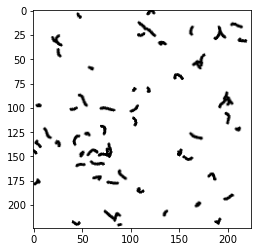

iteration: 0


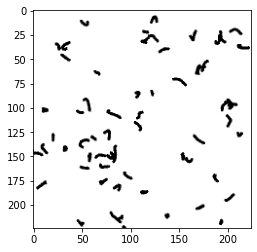

render loss: 0.07043565809726715
iteration: 50


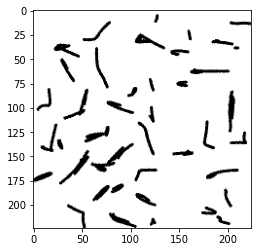

render loss: 0.07603547722101212
iteration: 100


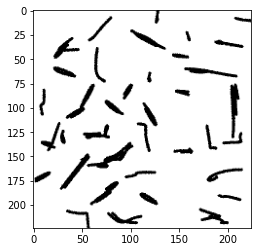

render loss: 0.039552267640829086
iteration: 150


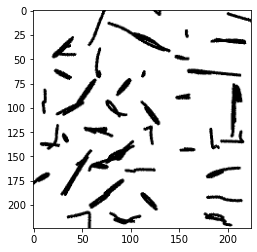

render loss: 0.039987824857234955
iteration: 200


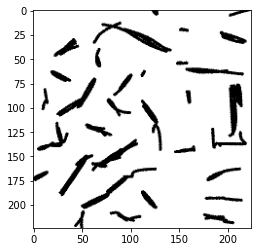

render loss: 0.02795904502272606
iteration: 250


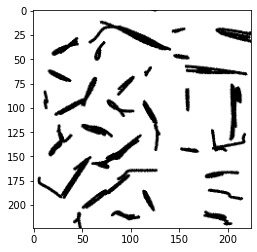

KeyboardInterrupt: 

In [7]:
random.seed(0)
np.random.seed(0)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(0)

path_svg = "/home/vinker/dev/background_project/experiements/06_08_mask_background/mask1_semi-complex_ViT_l4_32s/mask1_semi-complex_ViT_l4_32s_seed0/svg_logs/svg_iter0.svg"
target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/semi-complex.jpeg"
# target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/complex-scene-crop.png"
# # target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/semi-complex_mask.png"
# # path_svg = "/home/vinker/dev/background_project/experiements/05_29_image_divide/easy-background-crop_ViT_l0_32s/easy-background-crop_ViT_l0_32s_seed0/svg_logs/svg_iter0.svg"
# target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/easy-background-crop.jpeg"



# device = torch.device("cuda" if (
#         torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
canvas_size=224
num_strokes=64
num_cp=4

target, mask = get_target(target_, device, image_scale=224)
# mask = torch.ones((1,224,224))
# print(mask.shape)
points_vars = get_initial_points_mask(torch.ones((1,224,224)), num_strokes, device, canvas_width=224, canvas_height=224)
# points_vars = get_initial_points(path_svg, target_, device) # list of tensors
points_vars = torch.stack(points_vars).unsqueeze(0).to(device)
points_vars = (points_vars - points_vars.min()) / (points_vars.max() - points_vars.min())
points_vars = 2*points_vars-1

mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

clip_conv_layer_weights=[0,0,0,0,1,0,0,0,0,0,0,0]
loss_clip = CLIPmaskLoss(clip_conv_layer_weights, mask)

im = optimize_through_net(target, points_vars, mlp, optimizer, loss_clip, device, canvas_size=224, num_strokes=num_strokes, num_cp=4,num_iter=2501, print_interval=50)
plt.imshow(im.detach().cpu().numpy())
plt.title("result")
plt.show()

In [6]:
from CLIP_.clip import model
a = nn.Sequential(*[model.ResidualAttentionBlock(768, 12, None), model.ResidualAttentionBlock(768, 12, None), model.ResidualAttentionBlock(768, 12, None)])
# a = model.ResidualAttentionBlock(768, 12, None)

x = torch.rand((50, 5, 768))
for t in a:
    x = t(x, torch.rand((50,50)))
    # print(t)
# y = a(x, torch.rand((50,50)))

In [7]:
a = torch.ones(3,7)
a[0,2] = 0
a[0,4] = 0
a[0,-1] = 0
a[2,0] = 0
a = torch.cat([torch.ones(3,1) * 2, a], dim=-1)
a = a.unsqueeze(1)
# print(a.shape, a.permute(0,2,1))
b = torch.bmm(a.permute(0,2,1), a)
print(b.shape)
# b = torch.cat((b, b[:,0]), dim=1)
print(b.shape)
# print(b.repeat(12,1,1).shape)
print(b[0])
rows = (b.sum (dim = 2) != 0)#.unsqueeze(-1)
print(rows)
c = b[rows].view(3,8,-1)
c
# print(b[1])
# print(b[2])
# b = a * a.T
# print(a * a.T)

torch.Size([3, 8, 8])
torch.Size([3, 8, 8])
tensor([[4., 2., 2., 0., 2., 0., 2., 0.],
        [2., 1., 1., 0., 1., 0., 1., 0.],
        [2., 1., 1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 1., 1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 1., 1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[ True,  True,  True, False,  True, False,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True, False,  True,  True,  True,  True,  True,  True]])


RuntimeError: shape '[3, 8, -1]' is invalid for input of size 160

In [ ]:
a = nn.Softmax()
a(torch.tensor([float('-inf'), 0.1]))

In [ ]:
1e-2

In [ ]:
a = torch.rand((10,20,30))
print(a.shape)
print(a.transpose(0, 1).shape)

In [ ]:
# att_k = blk.attn_keys # [50, 5, 768]
att_k = torch.rand((50, 5, 768)).transpose(1,0)
# (prev) shape is torch.Size([60, 50, 64]) 60 = 12 * 5
print(att_k.shape)

# x = x[0]  # TEMP: getting rid of redundant dimension, TBF
# b = torch.cosine_similarity(att_k, att_k, dim=-1)
print(b.shape)
norm1 = att_k.norm(dim=-1, keepdim=True)
print(norm1.shape)
factor = torch.clamp(norm1 @ norm1.permute(0, 2, 1), min=1e-08)
print(factor.shape)
sim_matrix = (att_k @ att_k.permute(0, 2, 1)) / factor
print(sim_matrix.shape)
# print(sim_matrix.sum(-1))

sim_matrix2 = torch.zeros((5, 50,50))
for t, b in enumerate(att_k):
    for i, x1 in enumerate(b):
        for j, x2 in enumerate(b):
            normx1 = x1.norm(dim=-1, keepdim=True)
            normx2 = x2.norm(dim=-1, keepdim=True)
            cos = (x1 @ x2.T) / (normx1 * normx2)
            sim_matrix2[t,i,j] = cos
        # print(cos.norm())
# self_sim = sim_matrix
print(torch.allclose(sim_matrix, sim_matrix2))
# print(sim_matrix[0,0])
# print(sim_matrix2[0,0])

In [ ]:
a = torch.rand((5,50,768))
b = a.mean(-1).mean(-1).sum()
print(b)
c = a.mean()
print(c)